In [1]:
import numpy as np
import torch
import matplotlib.pylab as pl
import ot
import sklearn
from sklearn import datasets
import pylab
import math
from tqdm import trange
import proplot as plot
plot.rc['figure.facecolor'] = "white"

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device='cpu'
dtype = torch.DoubleTensor
print('Used device: '+device)

Used device: cpu


In [3]:
get_rot= lambda theta : np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta),np.cos(theta)]])
def make_blobs_reg(n_samples, n_blobs, scale=.5):
    per_blob=int(n_samples/n_blobs)
    result = np.random.randn(per_blob,2) * scale + 5
    theta=(2*np.pi)/(n_blobs)
    for r in range(1,n_blobs):
        new_blob=(np.random.randn(per_blob,2) * scale + 5).dot(get_rot(theta*r))
        result = np.vstack((result,new_blob))
    return result

# random MoG
def make_blobs_random(n_samples, n_blobs, scale=.5, offset=3):
    per_blob=int(n_samples/n_blobs)
    result = np.random.randn(per_blob,2) * scale + np.random.randn(1,2)*offset
    for r in range(1,n_blobs):
        new_blob=np.random.randn(per_blob,2) * scale + np.random.randn(1,2)*offset
        result = np.vstack((result,new_blob))
    return result

#%%
def make_spiral(n_samples, noise=.5):
    n = np.sqrt(np.random.rand(n_samples,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_samples,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_samples,1) * noise
    return np.array(np.hstack((d1x,d1y)))

def make_cube(n_samples,dim):
    n_samples=int(n_samples)
    return np.random.random((n_samples, dim)) * 2 - 1

In [4]:
def make_data(expe,n_samples,dim=2):
    if expe=='spirals':
        r=2.5
        xs = make_spiral(n_samples=n_samples, noise=1)
        xt = make_spiral(n_samples=n_samples, noise=1).dot(get_rot(r))
    elif expe=='mog_reg':
        r=.5
        xs = make_blobs_reg(n_samples=n_samples, n_blobs=5)
        xt = make_blobs_reg(n_samples=n_samples, n_blobs=5).dot(get_rot(r))
    elif expe=='mog_random':
        xs = make_blobs_random(n_samples=n_samples, scale=.3,n_blobs=10)
        xt = make_blobs_random(n_samples=n_samples, scale=.3,n_blobs=10)
    elif expe=='custom':
        xs = make_blobs_random(n_samples=n_samples, scale=.3,n_blobs=1,offset=0)-6
        xt = make_spiral(n_samples=n_samples, noise=1)
    elif expe=='two_moons':
        X, y = sklearn.datasets.make_moons(n_samples=n_samples, noise=0.05)
        xs = X[y==0,:]
        xt = X[y==1,:]
    elif expe=='cube':
        #xs=Transform_cube(make_cube(n_samples,dim))
        xs=make_cube(n_samples,dim)
        xt=make_cube(n_samples,dim)
    elif expe=='gaussians' :
        mu_s = np.random.randint(-10,5,dim)
        cov_s = np.diag(np.random.randint(1,10,dim))
        cov_s = cov_s * np.eye(dim)

        mu_t = np.random.randint(-5,10,dim)
        cov_t = np.diag(np.random.randint(1,10,dim))
        cov_t = cov_t * np.eye(dim)
        
        xs = np.random.multivariate_normal(mu_s, cov_s, n_samples)
        xt = np.random.multivariate_normal(mu_t, cov_t, n_samples)
    return xs,xt

In [5]:
def upperW2_smooth_pos(X,Y,theta,s=1,std=0):
    n,dim=X.shape
    
    X_line=torch.matmul(X,theta)
    Y_line=torch.matmul(Y,theta)
    
    X_line_sort,u=torch.sort(X_line,axis=0)
    Y_line_sort,v=torch.sort(Y_line,axis=0)
    
    X_sort=X[u]
    Y_sort=Y[v]
    
    Z_line=(X_line_sort+Y_line_sort)/2
    Z=Z_line[:,None]*theta[None,:]
    
    W_XZ=torch.sum((X_sort-Z)**2)/n
    W_YZ=torch.sum((Y_sort-Z)**2)/n
    
    X_line_extend = X_line_sort.repeat_interleave(s,dim=0)#.requires_grad_()
    X_line_extend_blur = X_line_extend + 0.5 * std * torch.randn(X_line_extend.shape).type(dtype)
    Y_line_extend = Y_line_sort.repeat_interleave(s,dim=0)#.requires_grad_()
    Y_line_extend_blur = Y_line_extend + 0.5 * std * torch.randn(Y_line_extend.shape).type(dtype)
    
    X_line_extend_blur_sort,u_b=torch.sort(X_line_extend_blur,axis=0)
    Y_line_extend_blur_sort,v_b=torch.sort(Y_line_extend_blur,axis=0)

    
    X_extend=X_sort.repeat_interleave(s,dim=0)
    Y_extend=Y_sort.repeat_interleave(s,dim=0)
    X_sort_extend=X_extend[u_b]
    Y_sort_extend=Y_extend[v_b]
    
    bary_extend=(X_sort_extend+Y_sort_extend)/2
    bary_blur=torch.mean(bary_extend.reshape((n,s,dim)),dim=1)
    
    W_baryZ=torch.sum((bary_blur-Z)**2)/n
    return -4*W_baryZ+2*W_XZ+2*W_YZ

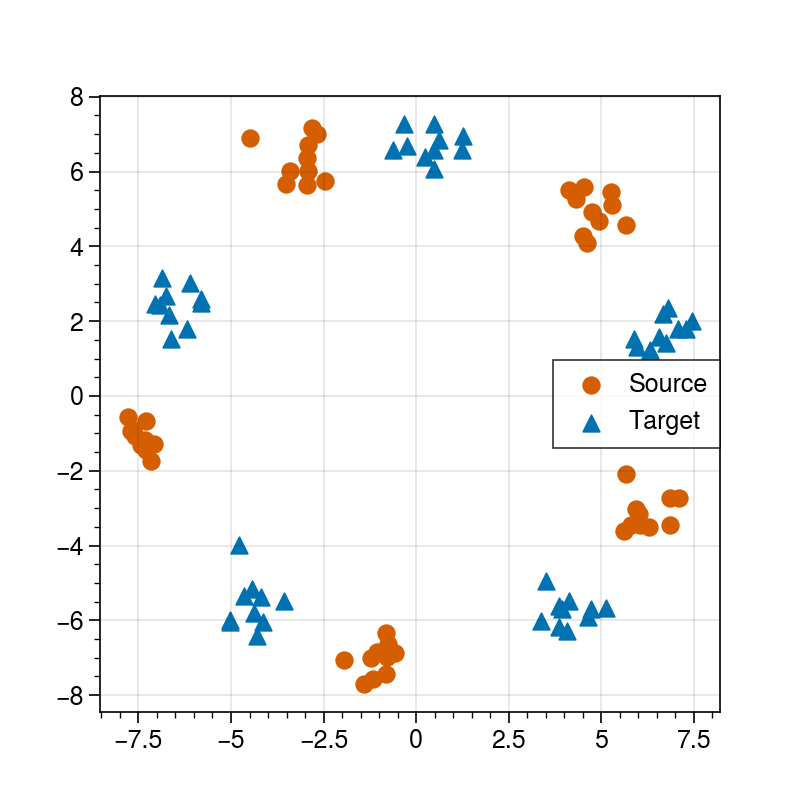

In [9]:
n=50
dim=2
xs,xt=make_data('mog_reg',n,dim)

#xs=np.array([[-1,1],[-2,-1]])
#xt=np.array([[1,1],[2,-1]])

X = torch.from_numpy(xs).to(device)
Y = torch.from_numpy(xt).to(device)
X=X.float()
Y=Y.float()

pl.figure(figsize=(4,4))
pl.scatter(xs[:, 0], xs[:, 1], c='C1', label='Source')
pl.scatter(xt[:, 0], xt[:, 1], c='C0', label='Target',marker="^")
pl.legend(loc=5)

In [10]:
p=1

In [13]:
X_cut=X[:,0:2]
Y_cut=Y[:,0:2]
num_proj=360*p
thetas = np.linspace(0, 2*np.pi, num_proj)
dire = np.array([(np.cos(theta),np.sin(theta)) for theta in thetas])
dir_torch=torch.from_numpy(dire).to(device)

msw_theta = [upperW2_smooth_pos(X_cut,Y_cut,p.float(),s=1,std=0) for p in dir_torch]
msw_theta_pos = [upperW2_smooth_pos(X_cut,Y_cut,p.float(),s=2000,std=.5) for p in dir_torch]
#msw_theta_mass = [upperW2_smooth_mass(X_cut,Y_cut,p.float(),s=100,std=.5) for p in dir_torch]

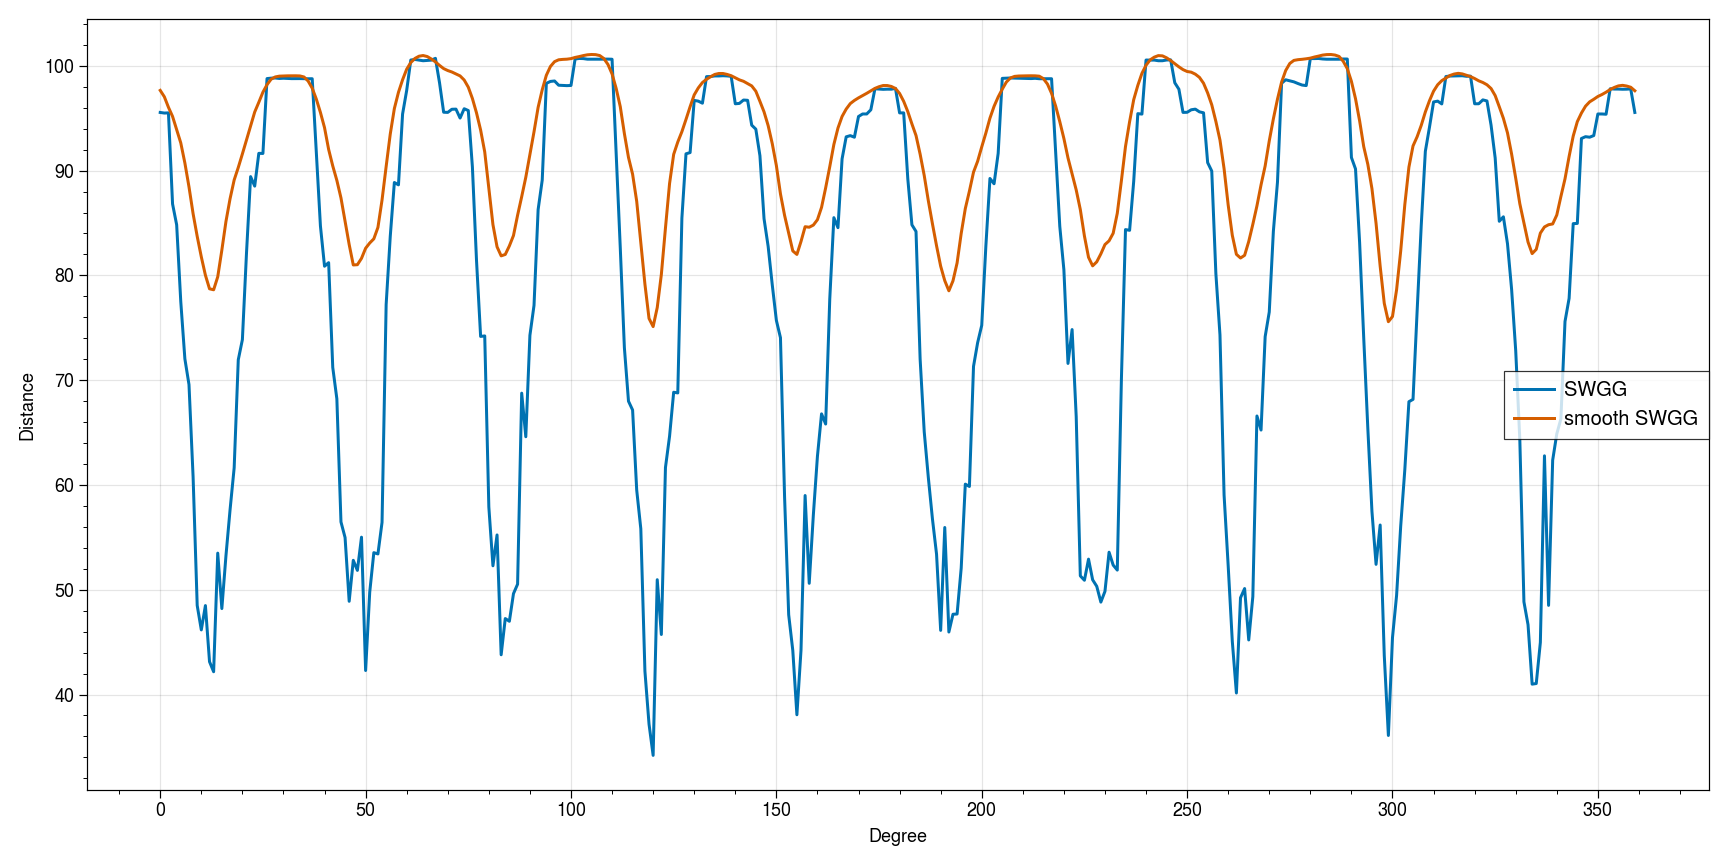

In [14]:
l=np.arange(0,360,1/p)
pl.figure(figsize=(12,6))
pl.plot(l,msw_theta, label="SWGG",c='C0')
pl.plot(l,msw_theta_pos, label="smooth SWGG",c='C1')
#pl.plot(msw_theta_mass, label="minSW mass",c='C2')
pl.xlabel('Degree')
pl.ylabel('Distance')
pl.tight_layout()
pl.legend(loc=5, prop={'size': 10})